### Group Prject - London Bike Rentals

In this project, you will work with the London Bikes dataset, which records daily bike rentals in the city along with key variables such as dates, weather conditions, and seasonality.

The goal is to apply the full data analytics workflow:

- Clean and prepare the dataset.

- Explore the data through visualisation.

- Construct and interpret confidence intervals.

- Build a regression model to explain variation in bike rentals.

- By the end, you will connect statistical concepts with practical Python analysis.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

In [32]:
#import data
bikes = pd.read_csv('Data/london_bikes.csv')
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend
0,2010-07-30T00:00:00Z,6897,2010,Fri,Jul,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False
1,2010-07-31T00:00:00Z,5564,2010,Sat,Jul,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True
2,2010-08-01T00:00:00Z,4303,2010,Sun,Aug,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True
3,2010-08-02T00:00:00Z,6642,2010,Mon,Aug,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False
4,2010-08-03T00:00:00Z,7966,2010,Tue,Aug,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False


**1. Data Cleaning**

Check for missing values across columns. How would you handle them?

Inspect the date column and ensure it is correctly formatted as datetime. Extract useful features (year, month, day, day of week, season).

Convert categorical variables (e.g., season, weather) to appropriate categories in Python.

Ensure numeric columns (e.g., bikes rented, temperature) are in the right format.

In [33]:
#inspect column types
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4934 non-null   object 
 1   bikes_hired    4934 non-null   int64  
 2   year           4934 non-null   int64  
 3   wday           4934 non-null   object 
 4   month          4934 non-null   object 
 5   week           4934 non-null   int64  
 6   cloud_cover    4901 non-null   float64
 7   humidity       4851 non-null   float64
 8   pressure       4903 non-null   float64
 9   radiation      4894 non-null   float64
 10  precipitation  4903 non-null   float64
 11  snow_depth     4632 non-null   float64
 12  sunshine       4903 non-null   float64
 13  mean_temp      4903 non-null   float64
 14  min_temp       4872 non-null   float64
 15  max_temp       4903 non-null   float64
 16  weekend        4934 non-null   bool   
dtypes: bool(1), float64(10), int64(3), object(3)
memory 

In [34]:
#convert date column to datetime format
bikes["date"] = pd.to_datetime(
    bikes["date"],
    format="%Y-%m-%dT%H:%M:%SZ",
    errors="coerce",
    utc=True
)

In [35]:
#Convert Months into sorted category
bikes["month"] = pd.Categorical(
    bikes["date"].dt.month_name(),
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

In [36]:
#This is where we checked on the null values
bikes.isna().sum()

#we identified quite some null values in the following columns
#cloud_cover, humidity, pressure, radiation, precipitation, snow_depth, sunshine, mean_temp, min_temp, max_temp
#not all columns necessarily indicate lack of data - some null values like in snow depth might represent 0 
#however when data on temperature is lacking, we can interpret that these values actually are incomplete

date               0
bikes_hired        0
year               0
wday               0
month              0
week               0
cloud_cover       33
humidity          83
pressure          31
radiation         40
precipitation     31
snow_depth       302
sunshine          31
mean_temp         31
min_temp          62
max_temp          31
weekend            0
dtype: int64

In [37]:
#We suggest dropping the na values in humidity, pressure, radiation, mean_temp, min_temp, max_temp completely
#Then we want to substitute the other values with 0

drop_na_subset = ["humidity", "pressure", "radiation", 
                "mean_temp", "min_temp", "max_temp"]
fill_zero_subset = ["cloud_cover", "precipitation", 
                  "snow_depth", "sunshine"]

bikes = bikes.dropna(subset=drop_na_subset)
bikes[fill_zero_subset] = bikes[fill_zero_subset].fillna(0)

In [38]:
#Extract season based on month (northern hemisphere in London)
conditions = [
    bikes["date"].dt.month.isin([12, 1, 2]),
    bikes["date"].dt.month.isin([3, 4, 5]),
    bikes["date"].dt.month.isin([6, 7, 8]),
    bikes["date"].dt.month.isin([9, 10, 11]),
]
choices = ["Winter", "Spring", "Summer", "Autumn"]
bikes["season"] = np.select(conditions, choices, default = 'Unknown')
bikes["season"] = pd.Categorical(
    bikes["season"],
    categories=["Winter", "Spring", "Summer", "Autumn"],
    ordered=True
)
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend,season
0,2010-07-30 00:00:00+00:00,6897,2010,Fri,July,30,6.0,65.0,10147.0,157.0,22.0,0.0,31.0,17.7,12.3,25.1,False,Summer
1,2010-07-31 00:00:00+00:00,5564,2010,Sat,July,30,5.0,70.0,10116.0,184.0,0.0,0.0,47.0,21.1,17.0,23.9,True,Summer
2,2010-08-01 00:00:00+00:00,4303,2010,Sun,August,30,7.0,63.0,10132.0,89.0,0.0,0.0,3.0,19.3,14.6,23.4,True,Summer
3,2010-08-02 00:00:00+00:00,6642,2010,Mon,August,31,7.0,59.0,10168.0,134.0,0.0,0.0,20.0,19.5,15.6,23.6,False,Summer
4,2010-08-03 00:00:00+00:00,7966,2010,Tue,August,31,5.0,66.0,10157.0,169.0,0.0,0.0,39.0,17.9,12.1,20.1,False,Summer


**2. Exploratory Data Analysis (EDA)**

Plot the distribution of bikes rented.

Explore how rentals vary by season and month.

Investigate the relationship between temperature and bikes rented.

**Deliverables:**

At least 3 clear visualisations with captions.

A short written interpretation of key patterns (seasonality, weather effects, etc.).



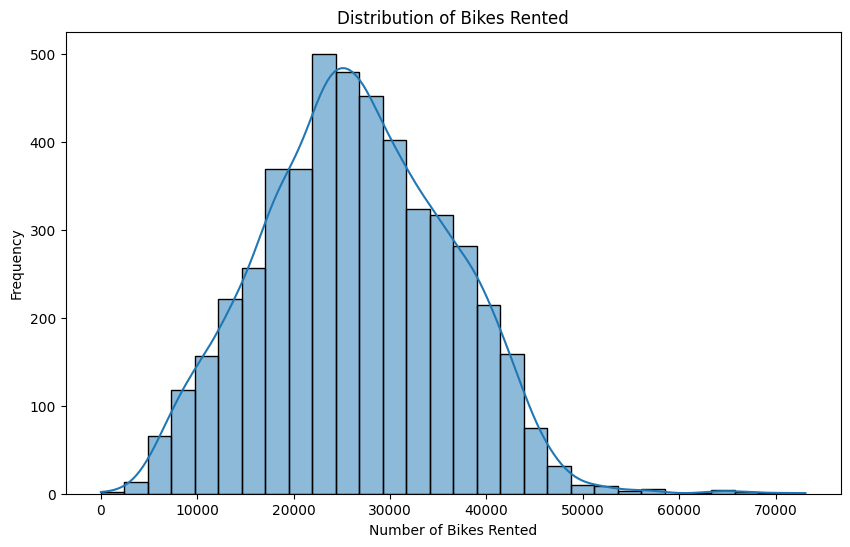

In [39]:
#plot distribution of bikes rented
plt.figure(figsize=(10, 6))
sns.histplot(bikes['bikes_hired'], bins=30, kde=True)
plt.title('Distribution of Bikes Rented')
plt.xlabel('Number of Bikes Rented')
plt.ylabel('Frequency')
plt.show()
#This graph shows the distribution of bikes rented for each day, you can see that there are very little days where under 10000 bikes where rented
#A couple days have even a number  hier than 50000. Most of the data however lies  between 10000 and 40000
#The distribution appears normal with a slight skew to the right

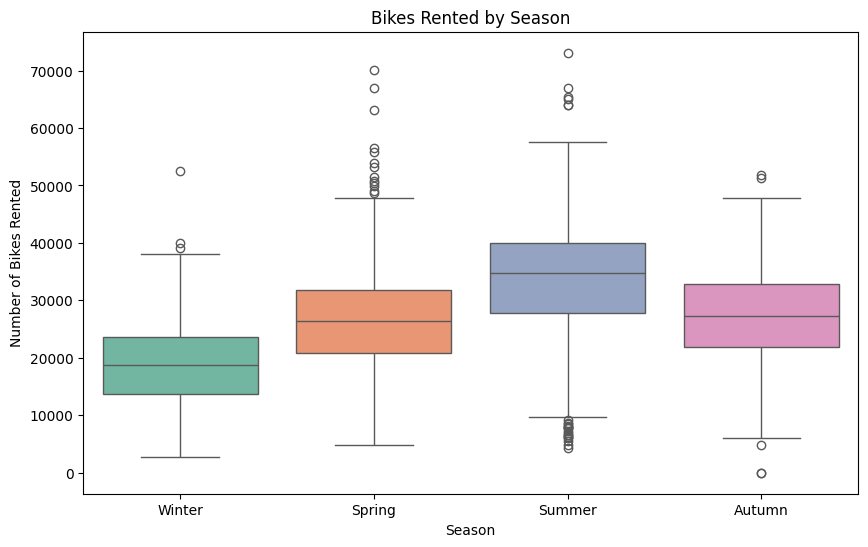

In [40]:
#explore how bikes rented varies by season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='bikes_hired', data=bikes, palette='Set2')
plt.title('Bikes Rented by Season')
plt.xlabel('Season')
plt.ylabel('Number of Bikes Rented')
plt.show()
#As hypothesised in our group before, the number of bikes rented in summer is on average the highest, followed by autumn and spring (both being very similar in mean)
#In spring however most values outside the IQR are found in higher bike rental numbers. For autumn the distribution doesnt seem to be so skewed,
# In winter there are by far the least rentals on average, with one large oulier at about 53000 

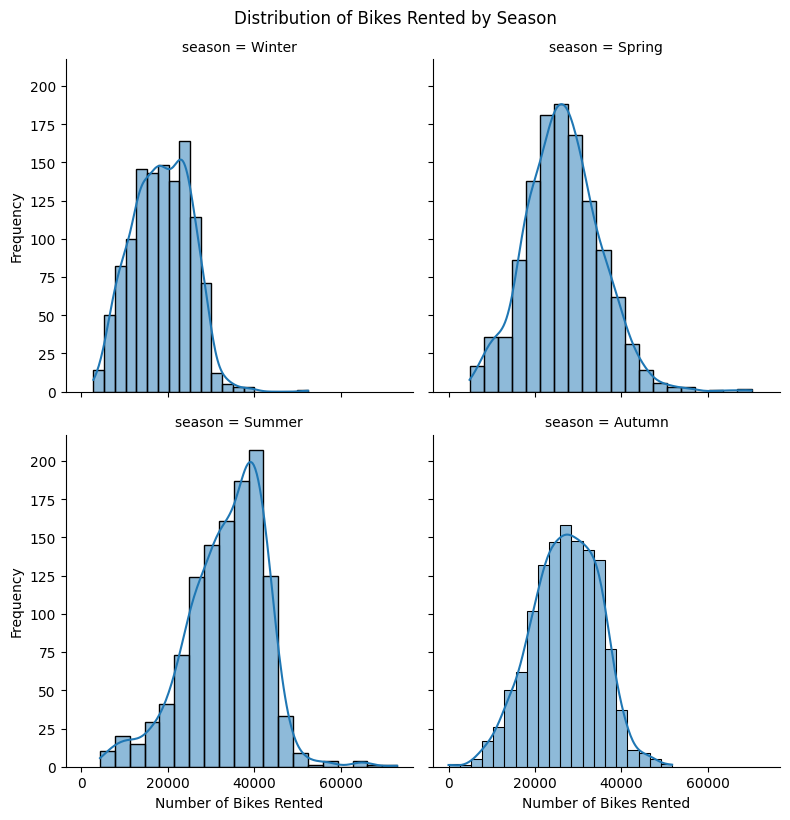

In [41]:
#histograms of bikes rented by season
g = sns.FacetGrid(bikes, col="season", col_wrap=2, height=4)
g.map(sns.histplot, "bikes_hired", bins=20, kde=True)
g.set_axis_labels("Number of Bikes Rented", "Frequency")
g.fig.suptitle('Distribution of Bikes Rented by Season', y=1.02)
plt.show()  
#This histogram confirms that in spring some days have very high numbers of bikes rented (strongest right tail)
#In autumn the distribution approximates a normal distribution very closely
#Summerdays seem to be the most variable

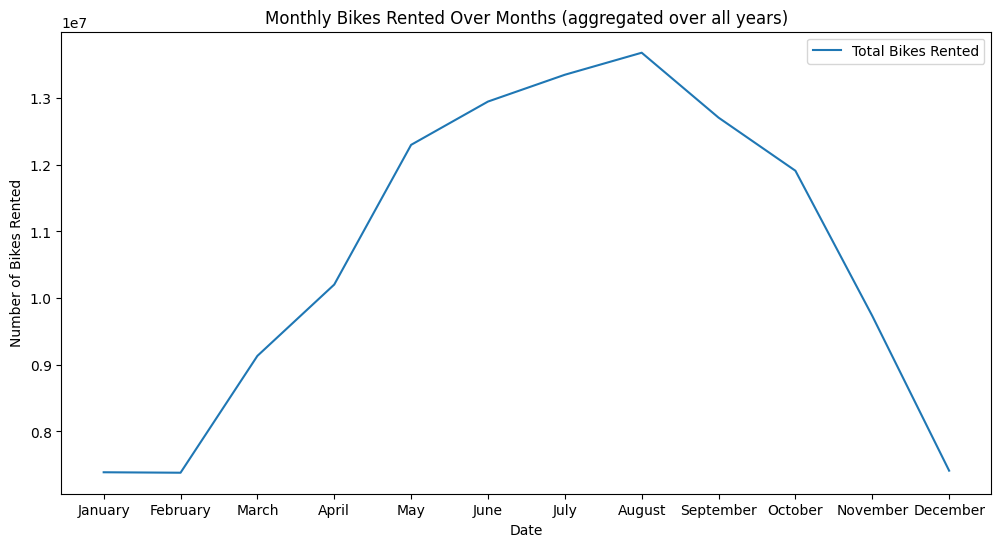

In [42]:
#lineplot of the sum and mean of bikes rented for each month over all years
bikes_monthly = (
    bikes.groupby(bikes["month"])
            .agg(total_bikes_rented=("bikes_hired", "sum"))
            .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=bikes_monthly, x="month", y="total_bikes_rented", label="Total Bikes Rented")
plt.title("Monthly Bikes Rented Over Months (aggregated over all years)")
plt.xlabel("Date")
plt.ylabel("Number of Bikes Rented")
plt.legend()
plt.show()
#This graph shows over all years in which months the number of bikes rented is the largest
#This graph is consistent with the findings before. We can see the highest numbers in the summer months, especially August
#The values fall in fall and reach their minimum in the winter months.
#In spring, more people will start riding their bikes again

In [43]:
bikes.info()
#Here we checked again if everything worked out well - and we needed this information for some discussion

<class 'pandas.core.frame.DataFrame'>
Index: 4842 entries, 0 to 4902
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           4842 non-null   datetime64[ns, UTC]
 1   bikes_hired    4842 non-null   int64              
 2   year           4842 non-null   int64              
 3   wday           4842 non-null   object             
 4   month          4842 non-null   category           
 5   week           4842 non-null   int64              
 6   cloud_cover    4842 non-null   float64            
 7   humidity       4842 non-null   float64            
 8   pressure       4842 non-null   float64            
 9   radiation      4842 non-null   float64            
 10  precipitation  4842 non-null   float64            
 11  snow_depth     4842 non-null   float64            
 12  sunshine       4842 non-null   float64            
 13  mean_temp      4842 non-null   float64            
 1

**3. Construct 95% confidence intervals for the mean number of bikes rented per season.**

Repeat the calculation per month.

Interpret the result:

What range of values do you expect the true mean to lie in?

Which seasons/months have higher or lower average demand?

Are there overlaps in the intervals, and what does that mean?

**Deliverables:**

A table or plot showing the mean and confidence intervals.

A short interpretation.

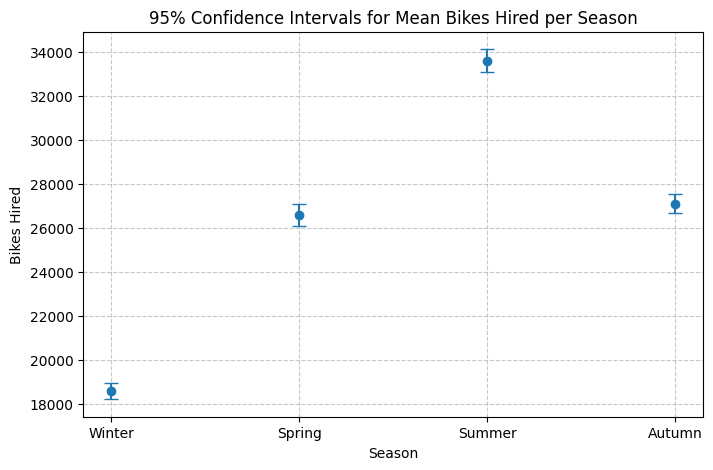

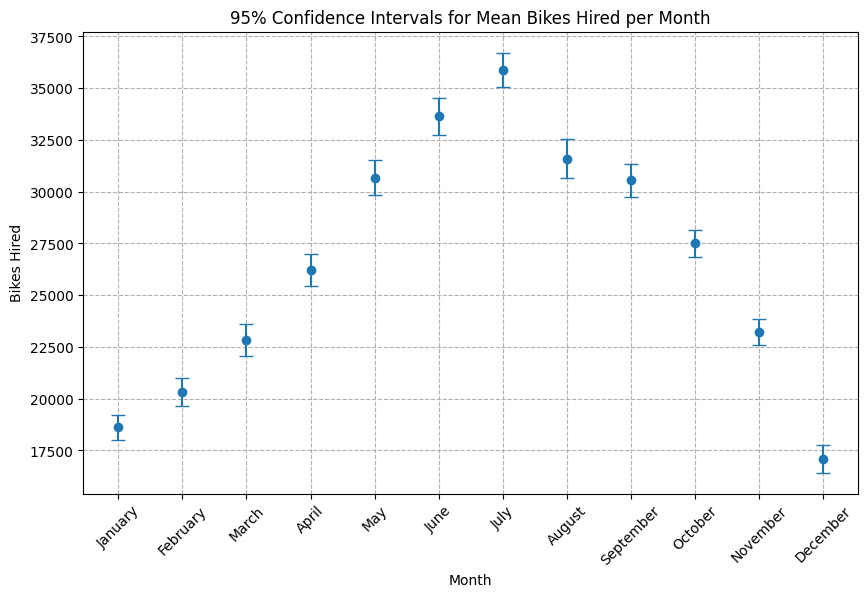

,month,mean_val,median_val,sd_val,count,t_critical,se,margin_error,ci_low,ci_high
0,January,18611.070529,18840.0,6084.103505,397,1.965973,305.352402,600.314458,18010.756071,19211.384987
1,February,20335.369146,20629.0,6553.321059,363,1.966539,343.960153,676.410990,19658.958156,21011.780136
2,March,22834.987500,23349.0,7751.037745,400,1.965927,387.551887,761.898834,22073.088666,23596.886334
3,April,26231.071979,26197.0,7782.291281,389,1.966097,394.577831,775.778242,25455.293738,27006.850221
4,May,30670.665835,30267.0,8549.928955,401,1.965912,426.963077,839.371983,29831.293852,31510.037819


In [44]:

from scipy import stats

# --- Confidence Interval Function ---
def ci_summary(df, group_col, value_col="bikes_hired"):
    summary = (
        df.groupby(group_col)
        .agg(
            mean_val=(value_col, "mean"),
            median_val=(value_col, "median"),
            sd_val=(value_col, "std"),
            count=(value_col, "size")
        )
        .reset_index()
    )

    # t-critical values
    summary["t_critical"] = summary["count"].apply(lambda n: stats.t.ppf(0.975, df=n-1))

    # Standard error
    summary["se"] = summary["sd_val"] / np.sqrt(summary["count"])

    # Margin of error
    summary["margin_error"] = summary["t_critical"] * summary["se"]

    # Confidence Interval bounds
    summary["ci_low"] = summary["mean_val"] - summary["margin_error"]
    summary["ci_high"] = summary["mean_val"] + summary["margin_error"]

    return summary

# --- CI per season ---
season_ci = ci_summary(bikes, "season")

# --- CI per month ---
month_ci = ci_summary(bikes, "month")

# --- Plot Season CI ---
plt.figure(figsize=(8,5))
plt.errorbar(season_ci["season"], season_ci["mean_val"], 
             yerr=season_ci["margin_error"], fmt="o", capsize=5)
plt.title("95% Confidence Intervals for Mean Bikes Hired per Season")
plt.ylabel("Bikes Hired")
plt.xlabel("Season")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

# --- Plot Month CI ---
plt.figure(figsize=(10,6))
plt.errorbar(month_ci["month"], month_ci["mean_val"], 
             yerr=month_ci["margin_error"], fmt="o", capsize=5)
plt.title("95% Confidence Intervals for Mean Bikes Hired per Month")
plt.ylabel("Bikes Hired")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=1)

plt.xticks(rotation=45)
plt.show()

# Show results
season_ci.head() 
month_ci.head()


## Seasonal Bike Rental Demand

### Ranges of True Means

* **Winter:** \~18,000–19,000
* **Spring:** \~26,000–27,000
* **Summer:** \~33,500–34,500
* **Autumn:** \~26,800–27,500

### Interpretation

* **Highest Demand:** Summer, with means well above 33k.
* **Lowest Demand:** Winter, dropping below 19k.
* **Intermediate:** Spring and Autumn around 26–27k.

### Overlaps

* **Spring vs. Autumn:** CIs overlap → no statistically significant difference.
* **Summer vs. Spring/Autumn:** No overlap → Summer demand is significantly higher.
* **Winter vs. all others:** No overlap → Winter demand is significantly lower.

---

## Monthly Bike Rental Demand

### Ranges of True Means

* **Lowest Months:**

  * January: \~18,000–19,000
  * December: \~16,500–17,500
* **Rising Spring:**

  * February: \~20,000–21,000
  * March–April: \~22,500–26,500
  * May: \~30,000–31,500
* **Peak Summer:**

  * June: \~33,000–34,500
  * **July: \~35,500–36,500 (highest)**
  * August: \~31,000–32,500
* **Declining Autumn:**

  * September: \~30,000–31,500
  * October: \~27,000–28,000
  * November: \~23,000–24,000

### Interpretation

* **Peak:** July is the clear peak, significantly higher than surrounding months.
* **Low:** December and January have the lowest demand.
* **Gradual Changes:**

  * Spring (March–May): steady increase.
  * Autumn (September–November): steady decrease.
* **Overlaps:**

  * June and August overlap slightly → both high demand, but July stands out as significantly higher.
  * Transitional months overlap (Spring and Autumn), indicating gradual shifts rather than abrupt changes.

---

## Final Insights

1. The true mean rentals per season/month **fall within the reported CIs** with 95% confidence.
2. **Summer (especially July)** shows the **highest demand**, while **Winter (December–January)** shows the **lowest demand**.
3. **Spring and Autumn** are transition periods with overlapping intervals, meaning differences between consecutive months are not statistically significant.
4. For operational planning:

   * Allocate **more bikes and resources in Summer**, especially July.
   * **Scale down in Winter**.
   * Adjust smoothly during Spring and Autumn.

---


**Regression Analysis**

What variables influence the number of bikes rented (y) and how? Build a regression model that best explains the variability in bikes rented.

**Interpret:**

Which predictors are significant?

What do the coefficients mean (in practical terms)?

How much of the variation in bike rentals is explained (R²)?

**Deliverables:**

Regression output table.

A short discussion of which factors matter most for predicting bike rentals.

---
### Regression Analysis for number of bikes rented
---

In [45]:
# Multiple linear regression model with several predictors
import statsmodels.formula.api as smf

model0_multiple = smf.ols('bikes_hired ~  wday + sunshine + month + mean_temp + precipitation', data=bikes).fit()
print(model0_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:            bikes_hired   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     326.1
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:32:41   Log-Likelihood:                -49243.
No. Observations:                4842   AIC:                         9.853e+04
Df Residuals:                    4821   BIC:                         9.866e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.529e+04    429

#### Summary
1. R² = 0.575 → Model explains ~58% of bike hire variation.
2. Model is statistically significant (F-statistic p < 0.001).
3. Key drivers: weekdays, seasonality (months), and weather variables.
4. Limitations: residuals show autocorrelation (DW = 0.68) and non-normality.
#### Key Points
1. Weekdays:
- Fewer hires on weekends (esp. Sunday).
- More hires midweek (Tue–Thu vs. Friday).
2. Months:
- Peak demand in summer (May–July, October).
- Sharp drop in December.
3. Weather:
- Increase in °C (temperature) increases bike hires.
- Increase in hires per extra hour of sunshine.
- Decrease in hires per mm of rain.
4. Diagnostics:
- Strong predictors, but autocorrelation present → time-series model could give better resuts

---
### Multi-collinearity (Optional)
---

Data types in your dataframe:
date             datetime64[ns, UTC]
bikes_hired                    int64
year                           int64
wday                          object
month                       category
week                           int64
cloud_cover                  float64
humidity                     float64
pressure                     float64
radiation                    float64
precipitation                float64
snow_depth                   float64
sunshine                     float64
mean_temp                    float64
min_temp                     float64
max_temp                     float64
weekend                         bool
season                      category
dtype: object

Numeric columns: ['bikes_hired', 'year', 'week', 'cloud_cover', 'humidity', 'pressure', 'radiation', 'precipitation', 'snow_depth', 'sunshine', 'mean_temp', 'min_temp', 'max_temp']


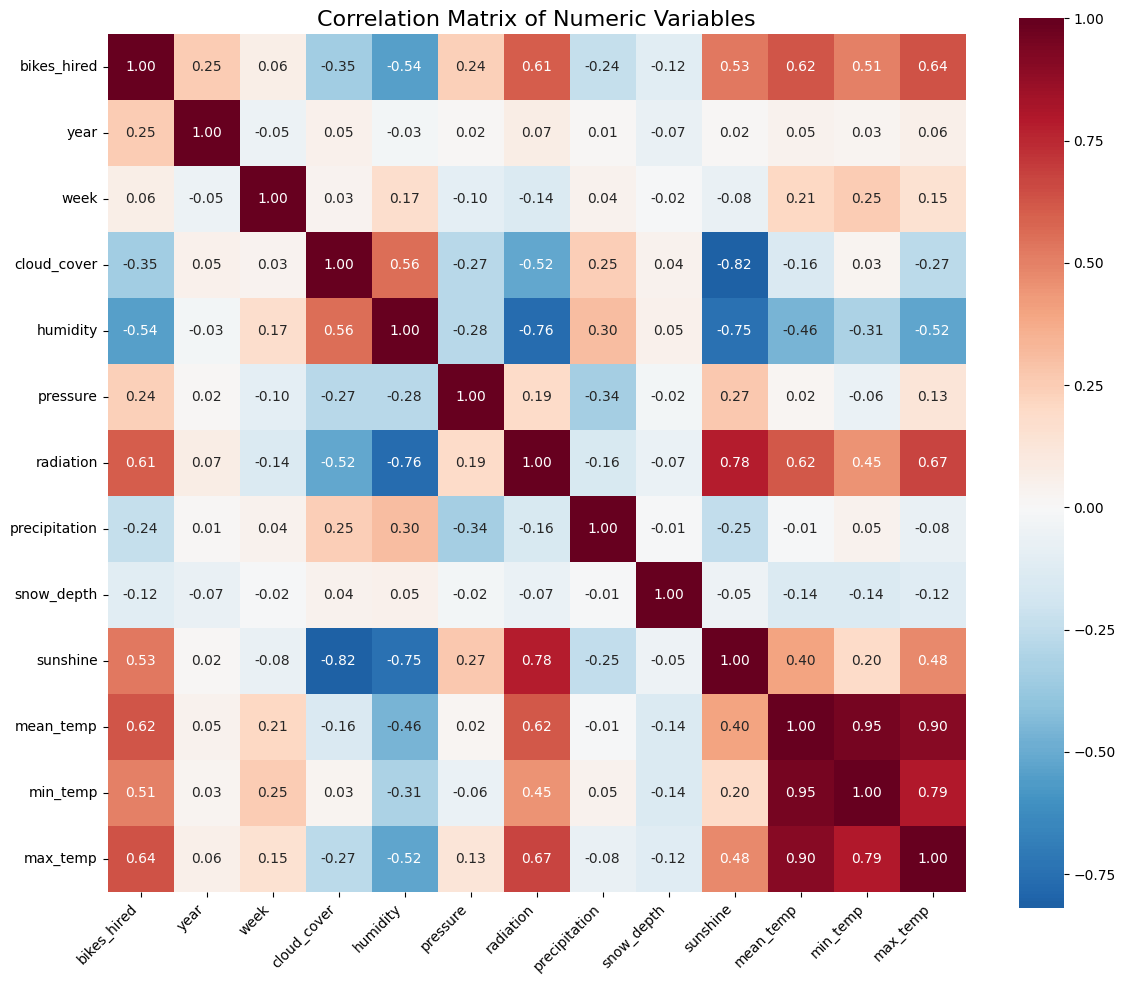


Converting categorical variables to dummy variables...
Features after encoding: ['week', 'sunshine', 'mean_temp', 'precipitation', 'month_August', 'month_December', 'month_February', 'month_January', 'month_July', 'month_June', 'month_March', 'month_May', 'month_November', 'month_October', 'month_September', 'wday_Mon', 'wday_Sat', 'wday_Sun', 'wday_Thu', 'wday_Tue', 'wday_Wed']

Data types in the VIF calculation matrix:
const              float64
week                 int64
sunshine           float64
mean_temp          float64
precipitation      float64
month_August          bool
month_December        bool
month_February        bool
month_January         bool
month_July            bool
month_June            bool
month_March           bool
month_May             bool
month_November        bool
month_October         bool
month_September       bool
wday_Mon              bool
wday_Sat              bool
wday_Sun              bool
wday_Thu              bool
wday_Tue              bool
wday_We

In [46]:
df = bikes
# First, let's check the data types of all columns
print("Data types in your dataframe:")
print(df.dtypes)

# Select only numeric columns for correlation matrix (excluding datetime, objects, categories, boolean)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {numeric_columns}")

# Calculate correlation matrix for numeric features only
corr_matrix = df[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Now let's prepare data for VIF calculation
# First, convert categorical columns to proper dummy variables
print("\nConverting categorical variables to dummy variables...")

# Convert category columns to strings first, then get dummies
df_for_vif = df.copy()

# Convert category columns to strings
category_columns = df_for_vif.select_dtypes(include=['category']).columns
for col in category_columns:
    df_for_vif[col] = df_for_vif[col].astype(str)

# Convert boolean column to numeric
bool_columns = df_for_vif.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df_for_vif[col] = df_for_vif[col].astype(int)

# Convert object columns (like 'wday') to strings
object_columns = df_for_vif.select_dtypes(include=['object']).columns
for col in object_columns:
    df_for_vif[col] = df_for_vif[col].astype(str)

# Select the features you used in your regression model
# Based on your OLS output, these seem to be the main ones
features_for_vif = ['month', 'wday', 'week', 'sunshine', 'mean_temp', 'precipitation']

# Create dummy variables, dropping the first category to avoid multicollinearity
X_dummies = pd.get_dummies(df_for_vif[features_for_vif], columns=['month', 'wday'], drop_first=True)

print(f"Features after encoding: {X_dummies.columns.tolist()}")

# Calculate VIF
X_with_const = add_constant(X_dummies)

# Ensure all data is numeric
print("\nData types in the VIF calculation matrix:")
print(X_with_const.dtypes)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values.astype(float), i) 
                  for i in range(X_with_const.shape[1])]

# Sort by VIF descending
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factors (VIF):")
print(vif_data.to_string())

# Highlight problematic VIF values
print("\n" + "="*50)
print("Features with severe multicollinearity (VIF >= 10):")
print(vif_data[vif_data['VIF'] >= 10])

print("\nFeatures with moderate multicollinearity (5 <= VIF < 10):")
print(vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)])

---

## Deliverables
A knitted HTML, one person per group to submit